In [24]:
import numpy as np
import torch
import pandas as pd
from torchvision.models.densenet import densenet161
import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
import ISBI_data
import ISBI_rareset
from metrics import *
from nets import ResNet, ResNext, ViT, ResNet152, Densenet161, effNetB7, effNetB6

# ckpt = torch.load('weights/resnext50_32x4d-epoch=027-val_arr=7.96.ckpt', map_location=torch.device('cpu'))

model = ResNext()
ckpt = torch.load('saved_model/ISBI-WeightedBCE-ResNext101-epoch=013-val_loss=0.0892.ckpt', map_location=torch.device('cpu'))
#ckpt = torch.load('data/checkpoints/ISBI-WeightedBCE-boosting-b1-ResNext101-epoch=006-val_loss=0.0882.ckpt', map_location=torch.device('cpu'))
new_dict = {k.replace('vit.', 'model.'): v for k, v in ckpt['state_dict'].items()}
model.load_state_dict(new_dict)
model.eval()
model.cuda()

testing_img_path = '../Test_Set/Test/'
testing_df = '../Test_Set/RFMiD_Testing_Labels.csv'
valset = ISBI_data.ISBIDataset(testing_df, testing_img_path, testing=True)
N = len(valset)
batch_size = 32
dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False, 
                        num_workers=24)

outs = np.zeros((N, 29))
labels = np.zeros((N, 29))
for i, (imgs, label, w) in enumerate(tqdm.tqdm(dataloader)):

    idx = i * batch_size
    imgs = imgs.cuda()
    out = model(imgs).detach().cpu().numpy()
    #out = np.round(out).astype('int').clip(1, None)
    outs[idx:idx + len(out),:] = out
    labels[idx:idx + len(label),:]  = label.detach().cpu().numpy()

/usr/mvl2/llzqd/ISBI/code/ISBI_data.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  w[i] = np.sum(c)/c[i]
100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


In [25]:
outs = torch.tensor(outs > 0).numpy()
rounded_pred = np.round(outs).astype('int')

In [63]:
np.round(outs)

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [26]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(labels, rounded_pred)

In [27]:
cm.shape

(29, 2, 2)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, rounded_pred)

ValueError: multilabel-indicator is not supported

In [29]:
confusion_matrix(rounded_pred[:,0], labels[:,0])

array([[123,  36],
       [ 11, 470]])

In [30]:
rounded_pred[:,0]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,

In [84]:
df = pd.read_csv(testing_df)
values = df.columns[2:29].tolist()
values.append('Other')

['DR',
 'ARMD',
 'MH',
 'DN',
 'MYA',
 'BRVO',
 'TSLN',
 'ERM',
 'LS',
 'MS',
 'CSR',
 'ODC',
 'CRVO',
 'TV',
 'AH',
 'ODP',
 'ODE',
 'ST',
 'AION',
 'PT',
 'RT',
 'RS',
 'CRS',
 'EDN',
 'RPEC',
 'MHL',
 'RP',
 'Other']

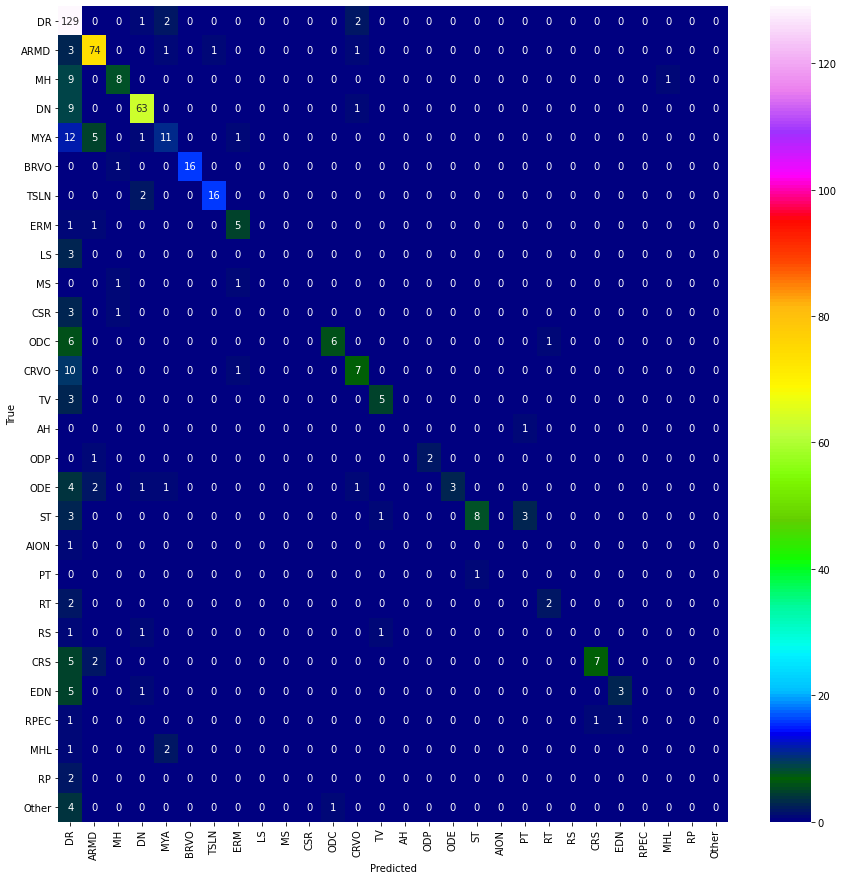

In [85]:
labels_1_disease = labels[labels[:,1:].sum(axis=1) <= 1]
labels_1_disease[:,0] = 1 - labels_1_disease[:,0]
labels_1_disease = labels_1_disease.argmax(axis=1)

outs_1_disease = outs[labels[:,1:].sum(axis=1) <= 1]
outs_1_disease[:,0] = 1 - outs_1_disease[:,0]
outs_1_disease = outs_1_disease.argmax(axis=1)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix(labels_1_disease, outs_1_disease),
            annot=True, fmt="d", cmap='gist_ncar', xticklabels=values, yticklabels=values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks = range(1,28)

In [34]:
labels[139]

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])